In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import open3d as o3d
import time
import os
import json
import matplotlib.pyplot as plt
from PIL import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def load_csv(file_path):
    try:
        df = pd.read_csv(file_path, sep=";")
        print(df.shape)
        if df.empty:
            print("The CSV file is empty.")
            return None
        return df
    except pd.errors.EmptyDataError:
        print("No data in the CSV file.")
        return None
    except pd.errors.ParserError:
        print("Error parsing the CSV file.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [4]:
def get_camera_matrices(camera_path):
    camdf = pd.read_csv(camera_path)
    camdf = camdf.set_index(camdf['Property'])
    camdf = camdf.drop(['Property'], axis = 1)

    fov = round(float(camdf.loc['fov']['Value']), 2)
    location_x = round(float(camdf.loc['location_x']['Value']), 2)
    location_y = round(float(camdf.loc['location_y']['Value']), 2)
    location_z = round(float(camdf.loc['location_z']['Value']), 2)
    rotation_euler_x = round(float(camdf.loc['rotation_euler_x']['Value']), 2)
    rotation_euler_y = round(float(camdf.loc['rotation_euler_y']['Value']), 2)
    rotation_euler_z = round(float(camdf.loc['rotation_euler_z']['Value']), 2)
    resolution_x = round(float(camdf.loc['resolution_x']['Value']), 2)
    resolution_y = round(float(camdf.loc['resolution_y']['Value']), 2)

    cx = resolution_x / 2
    cy = resolution_y / 2
    fx = cx / np.tan(np.radians(fov / 2))
    fy = fx

    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1]
    ])

    rotation_euler = np.radians([rotation_euler_x, rotation_euler_y, rotation_euler_z])
    R_matrix = R.from_euler('xyz', rotation_euler).as_matrix()

    t = np.array([location_x, location_y, location_z]).reshape((3, 1))

    extrinsic = np.hstack((R_matrix, t))
    extrinsic = np.vstack((extrinsic, np.array([0, 0, 0, 1])))

    return int(resolution_x), int(resolution_y), K, extrinsic

In [5]:
def get_loaded_camera_matrices(camera_path):
    with open(camera_path, 'r') as f:
        loaded_data = json.load(f)
        K_loaded = np.array(loaded_data['K'])
        RT_loaded = np.array(loaded_data['RT'])
        resx = int(loaded_data['resolution_x'])
        resy = int(loaded_data['resolution_y'])

    return resx, resy, K_loaded, RT_loaded

In [6]:
def get_point_cloud(file_path, noise = False):
    df = load_csv(file_path)
    if noise: coord = ['X', 'Y', 'Z']
    else: coord = ['X_noise', 'Y_noise', 'Z_noise']

    points = df[coord].values
    colors = df[['red', 'green', 'blue']].values

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    return point_cloud

In [7]:
def compute_projection_matrix(icm, ecm):
    """
    Compute the projection matrix P from intrinsic matrix icm and extrinsic matrix ecm.

    Parameters:
    - icm: Intrinsic matrix (3x3 numpy array)
    - ecm: Extrinsic matrix (4x4 numpy array)

    Returns:
    - P: Projection matrix (3x4 numpy array)
    """

    R = ecm[:3, :3] 
    t = ecm[:3, 3].reshape(-1, 1)

    # Compute projection matrix P = K * [R | t]
    P = np.dot(icm, np.hstack((R, t)))

    return P

In [8]:
def show_projection(image_path, p2d):
    image = Image.open(image_path)

    image_np = np.array(image)

    points = np.array(p2d)

    x = points[:, 0]
    y = points[:, 1]

    plt.imshow(image_np)

    plt.scatter(x, y, color='blue', marker='o', alpha=0.1)

    plt.title('Image with Points')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')

    plt.show()

## OPEN 3D VIS

(45605, 14)


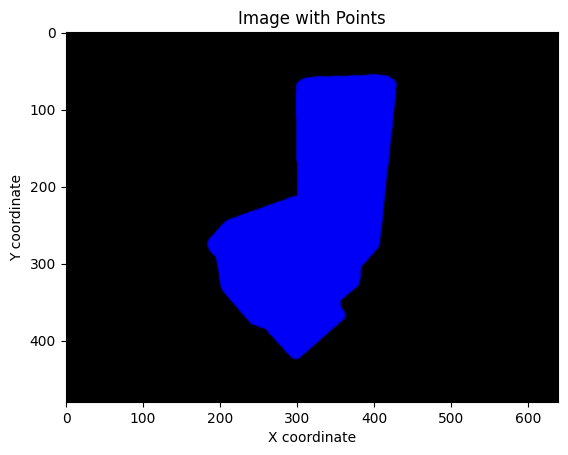

Sat Jun 15 22:07:07 2024
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
Stopped by user


In [9]:
def visualize_point_cloud_and_project(file_path, camera_path, image_path, noise = False):

    pcd = get_point_cloud(file_path, noise)

    resx, resy, icm, ecm = get_loaded_camera_matrices(camera_path)

    Points2D = []

    P = compute_projection_matrix(icm, ecm)

    points_np = np.asarray(pcd.points)

    for i in range(len(points_np)):
        point = points_np[i]
        point = list(point)
        point.append(1)

        point_3D = np.array(point).reshape((4, 1))

        point_2D_homogeneous = np.dot(P, point_3D)

        point_2D = point_2D_homogeneous / point_2D_homogeneous[2]

        Points2D.append([point_2D[0, 0], point_2D[1, 0]])

    show_projection(image_path, Points2D)

    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Virtual Information Space', width=950, height=1080, left=0, top=35)
    vis.add_geometry(pcd)

    cameraLines = o3d.geometry.LineSet.create_camera_visualization(view_width_px=resx, view_height_px=resy, intrinsic = icm, extrinsic = ecm)
    vis.add_geometry(cameraLines)

    last_modified_time = os.path.getmtime(file_path)

    print(time.ctime(last_modified_time))

    try:
        while True:
            current_modified_time = os.path.getmtime(file_path)
            
            if current_modified_time != last_modified_time:
                temp = get_point_cloud(file_path, noise)
                if temp is not None: 
                    pcd = temp
                    print(pcd.points)
                    vis.clear_geometries()
                    vis.add_geometry(pcd)
                last_modified_time = current_modified_time
            
            vis.update_geometry(pcd)
            vis.poll_events()
            vis.update_renderer()

    except KeyboardInterrupt:
        print("Stopped by user")
        
    vis.destroy_window()

    return Points2D

file_path = 'C:\\Programming\\Fourth Semester\\PointVIS\\PointVIS\\assets\\output\\toilet4_frames_17_to_17.csv'
camera_path = 'C:\\Programming\\Fourth Semester\\PointVIS\\PointVIS\\assets\\output\\camera4.csv'
image_path = 'C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output/toilet4_frame_17_image_segmented.png'
p2d = visualize_point_cloud_and_project(file_path = file_path, image_path=image_path, noise = False, camera_path = camera_path)